In [1]:
%matplotlib notebook
from SimPEG import Mesh, Utils, Maps, PF
from SimPEG.Utils import mkvc
import numpy as np
import scipy as sp
from matplotlib.colors import LightSource
import os
import segypy
import GeoToolkit
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from matplotlib import patches



In [2]:
work_dir = 'C:\\Users\\DominiqueFournier\\Dropbox\\Projects\\Kevitsa\\Kevitsa\\Modeling\\'

MAGsurvey = Utils.io_utils.readUBCmagneticsObservations(work_dir + '\\MAG\\Airborne\\VTEM_FLT40m_IGRF52800nT.dat')[0]
GRAVsurvey = Utils.io_utils.readUBCgravityObservations(work_dir + '\\GRAV\\gravKevitsa84_reproc_Drapped1p1m_DwnS50m.grv')
topo = np.genfromtxt(work_dir + '\\Kevitsa.topo', skip_header=1)
# mL2 = Mesh.TreeMesh.readModelUBC(mesh, work_dir + 'SimPEG_MVI_S_TileInv\\Run1\\MVI_C_TOT.amp')
hullMAG = np.loadtxt(work_dir + "MagData_Hull.txt")
hullGRAV = np.loadtxt(work_dir + "GravityData_Hull.txt")

In [3]:
def read_GOCAD_pl(tsfile):
    """

    Read GOCAD polyline (*.pl) file
    INPUT:
    plfile: Segment surface

    OUTPUT:
    vrts : Array of vertices in XYZ coordinates [n x 3]
    segs : Array of index for segments [m x 2]. 

    Author: @fourndo


    """

    import re

    fid = open(tsfile, 'r')
    line = fid.readline()

    # Skip all the lines until the vertices
    VRTX, SEGS = [], []
    vrtx, segs = [], []
    while not re.match('END\n', line):
        line = fid.readline()

        if re.match('ILINE', line):
            
            if vrtx:
                
                VRTX += [np.r_[vrtx]]
            if segs: 
                SEGS += [np.r_[segs]]
            vrtx = []
            segs = []

        # Run down all the vertices and save in array
        if re.match('VRTX', line):
            l_input = re.split('[\s*]', line)
            temp = np.array(l_input[2:5])
            vrtx.append(temp.astype(np.float))

        # Run down all the vertices and save in array
        if re.match('SEG', line):
            l_input = re.split('[\s*]', line)
            temp = np.array(l_input[1:3])
            segs.append(temp.astype(np.int))

        
    VRTX += [np.r_[vrtx]]
    SEGS += [np.r_[segs]]
            
    return VRTX, SEGS

def plotGeology(VRTX, faults, faultsOnly=False, ax=None, fill=True, linewidth=1, zorder=0):
    patches= []
    pcolor = []
    ii = -1
    im =[]
    
    if faultsOnly is False:
        if VRTX:
            for unit in VRTX:
                ii+=1
                for vrtx in unit:

                    if fill:
                        poly2D = Polygon(vrtx[:,0:2])
                        pcolor += [cpool[units[ii]]]
                        patches.append(poly2D)

                    plt.plot(vrtx[:,0],vrtx[:,1],'k', linewidth=linewidth, zorder=zorder)

            p = PatchCollection(patches, facecolor=pcolor)
            im = ax.add_collection(p)

    for unit in faults:
        for vrtx in unit:
            plt.plot(vrtx[:,0],vrtx[:,1],'k--', linewidth=linewidth, zorder=zorder)
        
    return im

In [4]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
xlim = [3492000, 3505000]
ylim = [7506250, 7515500]
inp_dir = 'C:\\Users\\DominiqueFournier\\Dropbox\\Projects\\Kevitsa\\Kevitsa\\Modeling\\'
# units = [
#     'Koitelainen', 'Gabbro', 'Opx','Peridotite', 'Dunite', 'Breccia',
#     'CarbPhy','Phyllite','Arkose','Arenite', 
#     'FelsicVol', 'MaficVol',   'Tuff', 'ChlVol', 'Komatite' ]
units = [
    'Koitelainen', 'Gabbro', 'Opx','Peridotite', 'Dunite', 'Breccia',
    'CarbPhy','Phyllite','Arkose','Arenite', 
    'FelsicVol', 'MaficVol',   'Tuff', 'ChlVol', 'Komatite' ]
lithoLabel = {'Dunite':'UDU',
           'Gabbro':'IGB',
           'Opx':'UPX',
           'Peridotite':'UKO',
           'Tuff':'MTF',
           'ChlVol':'CHV',
           'Komatite':'VMO',
          'MaficVol':'VMO',
          'FelsicVol':'FVS',
           'Arkose':'ARK',
           'Arenite':'ARN',
           'CarbPhy':'MPHB',
           'Phyllite':"MPH",
           'Breccia':'BXH',
           'Koitelainen':'KGB'
          }


cpool = {'Koitelainen':np.r_[120, 120, 120]/255,
         'Dunite':np.r_[255, 255, 255]/255,
         'Gabbro':np.r_[200, 200, 200]/255,
         'Opx':np.r_[140, 140, 140]/255,
         'Peridotite':np.r_[176, 245, 184]/255,
         'Tuff':np.r_[0, 160, 18]/255,
         'ChlVol':np.r_[0, 120, 0]/255,
        'Komatite':np.r_[0, 75, 0]/255,
        'MaficVol':np.r_[0, 200, 0]/255,
        'FelsicVol':np.r_[178, 255, 104]/255,
         'Arkose':np.r_[255, 174, 0]/255,
         'Arenite':np.r_[255, 225, 140]/255,
         'CarbPhy':np.r_[110, 190, 255]/255,
         'Phyllite':np.r_[139, 241, 255]/255,
        'Breccia':np.r_[208, 140, 212]/255}


lithoTS = {'Dunite':'UBC_litho_Dunite_pl.pl',
           'Gabbro':'UBC_Litho_Gabbro_pl.pl',
           'Opx':'UBC_litho_Kevitsa_pl.pl',
           'Peridotite':'UBC_litho_Peridotite_pl.pl',
           'Tuff':'UBC_litho_Mafic_Tuff_pl.pl',
           'ChlVol':'UBC_litho_Mafic_Tuff_pl.pl',
           'ChlVol':'UBC_litho_Chloritic_Volcanic_pl.pl',
           'Komatite':'UBC_litho_Basalt_Komatiite_pl.pl',
          'MaficVol':'UBC_litho_Mafic_Volcanic_pl.pl',
           'FelsicVol':'UBC_litho_Felsic_pl.pl',
           'Arkose':'UBC_litho_Arkose_pl.pl',
           'Arenite':'UBC_litho_Arenite_pl.pl',
           'CarbPhy':'UBC_litho_CarboPhyllite_pl.pl',
           'Phyllite':"UBC_litho_Phyllite_pl.pl",
           'Breccia':'UBC_litho_Breccia_pl.pl',
           'Koitelainen':'UBC_litho_Koitelainen_pl.pl'}
cmap = []
VRTX, SEGS = [], []
for label in units:
    vrtx, segs = read_GOCAD_pl(inp_dir + "Sections\\Litho\\" + lithoTS[label])
    VRTX += [vrtx]
    SEGS += [segs]
    
faults = read_GOCAD_pl(inp_dir + "Sections\\Litho\\UBC_Fault_pl.pl")


In [5]:
loadDir = "C:\\Users\DominiqueFournier\\Dropbox\\Projects\\Kevitsa\\Kevitsa\\Data\\Kevitsa_data\\Kevitsa_data\\Seismic\\2D_Seismic\\"
segFile = "E5_MIG_DMO_FINAL_DEPTH.sgy"

segypy.verbose=1

SH = segypy.getSegyHeader(loadDir+segFile)
STH = segypy.getAllSegyTraceHeaders(SH)

#%% Read Segy File
[DataE5,SH,STH]=segypy.readSegy(loadDir+segFile)

xxE5, yyE5, zzE5 = STH['SourceX'], STH['SourceY'], np.arange(-5265,240,5)# SH['time']*1000

# xx = xx-xx.min()+3493000
# yy = yy**0. * 7511535
llE5 = ((xxE5-xxE5[0])**2. + (yyE5-yyE5[0])**2.)**0.5


XE5, YE5 = np.kron(np.ones_like(zzE5),xxE5), np.kron(np.ones_like(zzE5),yyE5)
ZE5 = np.kron(zzE5,np.ones_like(xxE5))

meshE5 = Mesh.TensorMesh([np.r_[llE5[1] - llE5[0], np.abs((llE5[1:] - llE5[:-1]))], np.r_[zzE5[1] - zzE5[0], np.abs((zzE5[1:] - zzE5[:-1]))]])
meshE5.x0 = [0., -5265.]


SegyPY0.57:  getSegyHeader : succesfully read C:\Users\DominiqueFournier\Dropbox\Projects\Kevitsa\Kevitsa\Data\Kevitsa_data\Kevitsa_data\Seismic\2D_Seismic\E5_MIG_DMO_FINAL_DEPTH.sgy
SegyPY0.57:  readSegy : Trying to read C:\Users\DominiqueFournier\Dropbox\Projects\Kevitsa\Kevitsa\Data\Kevitsa_data\Kevitsa_data\Seismic\2D_Seismic\E5_MIG_DMO_FINAL_DEPTH.sgy
SegyPY0.57:  getSegyHeader : succesfully read C:\Users\DominiqueFournier\Dropbox\Projects\Kevitsa\Kevitsa\Data\Kevitsa_data\Kevitsa_data\Seismic\2D_Seismic\E5_MIG_DMO_FINAL_DEPTH.sgy
SegyPY0.57:  filesize=3765240
SegyPY0.57:  bps=    4
SegyPY0.57:  nd=940410
SegyPY0.57:  readSegyData : Reading segy data
SegyPY0.57:  readSegyData : SEG-Y revision = 0
SegyPY0.57:  readSegyData : DataSampleFormat=1(IBM Float)
SegyPY0.57:   ns=1101
SegyPY0.57:  readSegyData : Finished reading segy data


In [6]:
# Load in geomodel
mesh3D = Mesh.TensorMesh.readUBC(work_dir + "\\GeoContacts_20m.msh")
contacts = Mesh.TensorMesh.readModelUBC(mesh3D, work_dir + "\\GeoContacts_20m.mod")

# Assign contact values to inversion mesh
tree3D = cKDTree(mesh3D.gridCC)

<IPython.core.display.Javascript object>


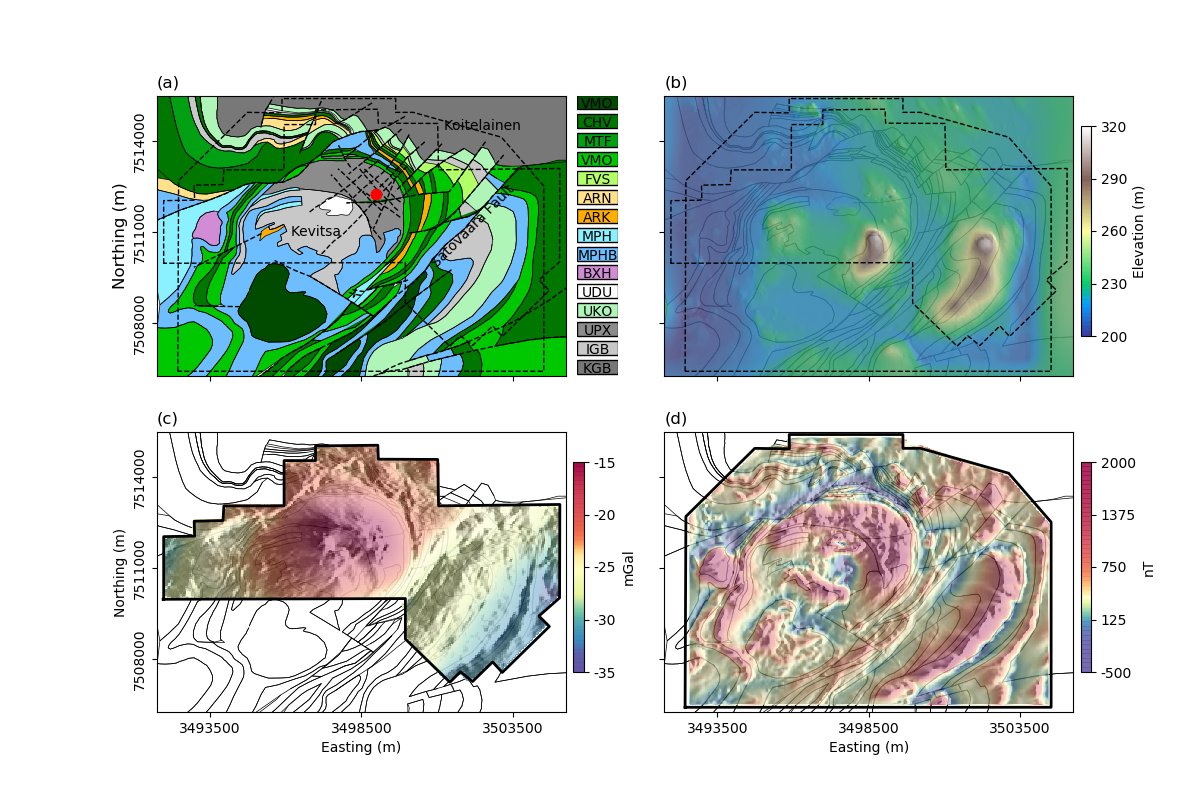

In [11]:
# Data plot
fig=plt.figure(figsize=(12,8))


y = [7508000, 7511000, 7514000]
x = [3493500, 3498500, 3503500]
xlim = [3491750, 3505250]
ylim = [7506250, 7515500]


axs=plt.subplot(2,2,3)
vmin = -35
vmax = -15

plotGeology(VRTX,[], ax=axs, faultsOnly=False, fill=False, linewidth=0.5)
# plotGeology(VRTX,faults, ax=axs, faultsOnly=True, fill=False, linewidth=2.)
X, Y, d_grid, im, CS = GeoToolkit.Mag.Simulator.plotDataHillside(
    GRAVsurvey.srcField.rxList[0].locs[:,0], 
    GRAVsurvey.srcField.rxList[0].locs[:,1], 
    GRAVsurvey.dobs, axs=axs, fill=True, contours=None, minCurvature=False,
                     vmin=vmin, vmax=vmax, resolution=50,
                     clabel=True, cmap='Spectral_r', ve=500., alpha=.8, alphaHS=0.5,
                     distMax=100, azdeg=270, altdeg=45,
                     equalizeHist='HistEqualized')

# plt.scatter(GRAVsurvey.rxLoc[:,0], GRAVsurvey.rxLoc[:,1], 0.1, c='k')


plt.plot(hullGRAV[:, 0], hullGRAV[:, 1], 'k', linewidth=2.)

axs.set_axisbelow(False)
axs.set_xlim(xlim)
axs.set_ylim(ylim)

axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=10, ha='center')
axs.set_xlabel('Easting (m)', size=10)

axs.set_yticks(list(map(int, y)))
axs.set_yticklabels(map(str, map(int, y)),size=10, rotation=90, va='center')
axs.set_ylabel('Northing (m)', size=10)
axs.set_title("(c)", loc='left')
axs.grid(False)
axs.set_aspect('equal')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0, pos.width*1.0, pos.height*1.0])

pos = axs.get_position()
axbar = plt.axes([pos.x0+0.26, pos.y0+0.05,  pos.width*.3, pos.height*.75])
cbar = plt.colorbar(im, orientation='vertical',format='%.0f')
cbar.set_ticks(np.linspace(vmin,vmax,5))
cbar.set_label("mGal", size=10)
# axbar.text(pos.x0, pos.y0-.5,'mGal', size=10)
axbar.axis('off')

            



# Plot gravity
axs = plt.subplot(2,2,4)



vmin, vmax = [-500, 2000]

plotGeology(VRTX,[], ax=axs, faultsOnly=False, fill=False, linewidth=0.5)
X, Y, d_grid, im, CS = GeoToolkit.Mag.Simulator.plotDataHillside(
                        MAGsurvey.srcField.rxList[0].locs[:,0],
                        MAGsurvey.srcField.rxList[0].locs[:,1], 
                        MAGsurvey.dobs , distMax=200, minCurvature=False,
                          axs=axs, cmap='Spectral_r', vmin=vmin, vmax=vmax, 
                          clabel=False, 
                          alpha=0.6, alphaHS=0.4, ve=1., azdeg=270, altdeg=45,
                          equalizeHist='HistEqualized')

plt.plot(hullMAG[:, 0], hullMAG[:, 1], 'k', linewidth=2.)


axs.set_axisbelow(False)
axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=10, ha='center')
axs.set_xlabel('Easting (m)', size=10)
axs.set_title("(d)", loc='left')
axs.set_yticks(list(map(int, y)))
axs.set_yticklabels([])
axs.set_ylabel('', size=10)
axs.grid(False)
axs.set_aspect('equal')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0, pos.width*1.0, pos.height*1.0])

pos = axs.get_position()
axbar = plt.axes([pos.x0+0.26, pos.y0+0.05,  pos.width*.3, pos.height*.75])
cbar = plt.colorbar(im, orientation='vertical',format='%.0f')
cbar.set_ticks(np.linspace(vmin,vmax,5))
cbar.set_label("nT", size=10)
# axbar.text(pos.x0, pos.y0-.5,'mGal', size=10)
axbar.axis('off')


cmap = plt.cm.gist_earth
# axs=plt.axes([pos.x0-0.4, pos.y0+0.2,  pos.width, pos.height])
axs = plt.subplot(2,2,2)
vmin, vmax = [200, 320]
cmap = plt.cm.gist_earth
plotGeology(VRTX,[], ax=axs, faultsOnly=False, fill=False, linewidth=0.5)
X, Y, d_grid, im, CS = GeoToolkit.Mag.Simulator.plotDataHillside(
                        topo[:, 0],
                        topo[:, 1], 
                        topo[:, 2] , distMax=500, minCurvature=False,
                          axs=axs, cmap='terrain', vmin=vmin, vmax=vmax, 
                          clabel=False, 
                          alpha=0.8, alphaHS=0.4, ve=1., azdeg=270, altdeg=45,
                          equalizeHist=False)

plt.plot(hullMAG[:, 0], hullMAG[:, 1], 'k--', linewidth=1.)
plt.plot(hullGRAV[:, 0], hullGRAV[:, 1], 'k--', linewidth=1.)

axs.set_axisbelow(False)
axs.set_xlim(xlim)
axs.set_ylim(ylim)

axs.set_xticks(list(map(int, x)))
axs.set_xticklabels([])
axs.set_xlabel("")

axs.set_title("(b)", loc='left')

axs.set_yticks(list(map(int, y)))
axs.set_yticklabels([])
axs.set_ylabel("")

axs.grid(False)
axs.set_aspect('equal')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0, pos.width, pos.height])

pos = axs.get_position()
axbar = plt.axes([pos.x0+0.26, pos.y0+0.05,  pos.width*.3, pos.height*.75])
cbar = plt.colorbar(im, orientation='vertical',format='%.0f')
cbar.set_ticks(np.linspace(vmin,vmax,5))
cbar.set_label("Elevation (m)", size=10)
# axbar.text(pos.x0, pos.y0-.5,'mGal', size=10)
axbar.axis('off')

axs = plt.subplot(2,2,1)
plotGeology(VRTX,[], ax=axs, fill=True, linewidth=0.5, zorder=2)
im = plotGeology(VRTX,faults, faultsOnly=True, ax=axs, linewidth=1, zorder=2)

# axs, im2, cbar = plotModelSections(
#     meshXY, mSliceLpXY, axs=axs, cmap="pink_r", vmin=vmin, vmax=vmax, 
#     alpha=1., colorbar=False, contourf=False)


# if mLP is not None:
#     plotModelSections(
#         meshXY, xySliceLpXY, axs=axs, fill=False,
#         subFact=int(subFact/8), scale=scale*2., vec='w')

plt.plot(hullMAG[:, 0], hullMAG[:, 1], 'k--', linewidth=1.)
plt.plot(hullGRAV[:, 0], hullGRAV[:, 1], 'k--', linewidth=1.)

axs.plot(3499000, 7512250,'r.',markersize=15)
# axs.text(3499200, 7512250,'Ni-Cu',bbox={'facecolor':'white', 'alpha':0.75},ha='left', va='center', size=10)
axs.text(3497000, 7511000,'Kevitsa',ha='center', va='center', size=10)
axs.text(3502200, 7511200,'Satovaara Fault',ha='center', va='center', size=10, rotation=45)
axs.text(3502500, 7514500,'Koitelainen',ha='center', va='center', size=10)

# plt.scatter(xxE5,yyE5,1,c='k')
# axs.text(xxE5[0], yyE5[0], 'E5', ha="right", va="top", size=12, bbox={'facecolor':'white', 'alpha':0.75})
# axs.text(xxE5[-1], yyE5[-1], "E5'", ha="left", va="bottom", size=12, bbox={'facecolor':'white', 'alpha':0.75})
# plt.scatter(xxE2,yyE2,1,c='k')
# axs.text(xxE2[0], yyE2[0], 'E2', ha="right", va="center", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# axs.text(xxE2[-1], yyE2[-1], "E2'", ha="left", va="center", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# plt.scatter(xxE2,yyE2,1,c='k')
# axs.text(xxE2[0], yyE2[0], 'E2', ha="right", va="center", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# axs.text(xxE2[-1], yyE2[-1], "E2'", ha="left", va="center", size=14, bbox={'facecolor':'white', 'alpha':0.75})

axs.set_xlim(xlim)
axs.set_ylim(ylim)

axs.set_xticks(list(map(int, x)))
axs.set_xticklabels([])
axs.set_ylabel('Northing (m)', size=12)
axs.set_xlabel('', size=14)

axs.set_yticks(list(map(int, y)))
axs.set_yticklabels(map(str, map(int, y)),size=10, rotation=90, va='center')
# axs.grid(True, 'k')
axs.set_aspect('equal')

axs.set_title("(a)", loc="left", size=12)
pos = axs.get_position()
# axs.set_position([pos.x0-.1, pos.y0, pos.width*1.2, pos.height*1.2])

pos = axs.get_position()
ax2 = plt.axes([pos.x0+0.35, pos.y0, pos.width*0.1, pos.height])
ii = 0.
jj=-0.06
for label in units:   
    jj +=0.0675
#     if jj > 0.9:
#         ii += 0.2
#         jj=0.05
    pp = ax2.add_patch(
        patches.Rectangle([ii,0+jj], 1., 0.05, facecolor=cpool[label], edgecolor='k'))
#     ax.text(26,62, 'Title',fontsize = 14,zorder = 6, color = 'k',
#                 bbox={'facecolor':'silver', 'alpha':0.5, 'pad':4})
    ax2.text(ii+0.5,0+jj+0.0175,lithoLabel[label], va='center', ha='center', size=10 )
    
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off')

fig.savefig('Kevitsa_Data.png', bbox_inches='tight', dpi=300)

In [35]:
def plotModelSections(mesh, m, normal='x', ind=0, vmin=None, vmax=None,
                      subFact=2, scale=1., xlim=None, ylim=None, vec='k', vector=True,
                      title=None, axs=None, actv=None, contours=None, fill=True, colorbar=True,
                      orientation='vertical', cmap='pink_r', alpha=1, contourf=False, zorder=1):

    """
    Plot section through a 3D tensor model
    """
    # plot recovered model
    nC = mesh.nC

    if vmin is None:
        vmin = m[np.isnan(m)!=True].min()

    if vmax is None:
        vmax = m[np.isnan(m)!=True].max()

    # Check for vector model
    if len(m) > nC:
        m_lpx = m[0:nC]
        m_lpy = m[nC:2*nC]
        
        if len(m) == 3*nC:
            m_lpz = m[2*nC:]
            
        if actv is not None:
            m_lpx[actv!=True] = np.nan
            m_lpy[actv!=True] = np.nan
            
            if len(m) == 3*nC:
                m_lpz[actv!=True] = np.nan

        amp = m_lpx**2. + m_lpy**2.
        m_lpx = (m_lpx).reshape(mesh.vnC, order='F')
        m_lpy = (m_lpy).reshape(mesh.vnC, order='F')
        
        if len(m) == 3*nC:
            amp += m_lpz**2.
            m_lpz = (m_lpz).reshape(mesh.vnC, order='F')
        
        amp = np.sqrt(amp).reshape(mesh.vnC, order='F')
    else:

        if actv is not None:
            m[actv!=True] = np.nan

        amp = m.reshape(mesh.vnC, order='F')

    xx = mesh.gridCC[:, 0].reshape(mesh.vnC, order="F")
    yy = mesh.gridCC[:, 1].reshape(mesh.vnC, order="F")
    
    if mesh.dim == 3:
        zz = mesh.gridCC[:, 2].reshape(mesh.vnC, order="F")

    if axs is None:
        fig, axs = plt.figure(), plt.subplot()

    if (normal == 'x') and (mesh.dim > 2):
        xx = yy[ind, :, :].T
        yy = zz[ind, :, :].T
        model = amp[ind, :, :].T

        if len(m) == 3*nC:
            mx = m_lpy[ind, ::subFact, ::subFact].T
            my = m_lpz[ind, ::subFact, ::subFact].T

    elif (normal == 'y') and (mesh.dim > 2):
        xx = xx[:, ind, :].T
        yy = zz[:, ind, :].T
        model = amp[:, ind, :].T

        if len(m) == 3*nC:
            mx = m_lpx[::subFact, ind, ::subFact].T
            my = m_lpz[::subFact, ind, ::subFact].T

    else:
        if mesh.dim ==3:
            if actv is not None:
                actIndFull = np.zeros(mesh.nC, dtype=bool)
                actIndFull[actv] = True
            else:
                actIndFull = np.ones(mesh.nC, dtype=bool)

            actIndFull = actIndFull.reshape(mesh.vnC, order='F')

            model = np.zeros((mesh.nCx, mesh.nCy))
            mx = np.zeros((mesh.nCx, mesh.nCy))
            my = np.zeros((mesh.nCx, mesh.nCy))
            for ii in range(mesh.nCx):
                for jj in range(mesh.nCy):

                    zcol = actIndFull[ii, jj, :]
                    model[ii, jj] = amp[ii, jj, np.where(zcol)[0][-ind]]

                    if len(m) == 3*nC:
                        mx[ii, jj] = m_lpx[ii, jj, np.where(zcol)[0][-ind]]
                        my[ii, jj] = m_lpy[ii, jj, np.where(zcol)[0][-ind]]

            xx = xx[:, :, ind].T
            yy = yy[:, :, ind].T
            model = model.T

            amp = np.kron(np.ones(mesh.nCz), mkvc(model.T))
            if len(m) == 3*nC:
                mx = mx[::subFact, ::subFact].T
                my = my[::subFact, ::subFact].T
                
        else:
            if len(m) > nC:
                mx = m_lpx[::subFact, ::subFact]
                my = m_lpy[::subFact, ::subFact]
            

    im2, cbar = [], []
    if fill:

        if contourf:
            print("In contourf")
            im2 = axs.contourf(xx, yy, amp,
                               30, vmin=vmin, vmax=vmax,
                               cmap=cmap, clim=[vmin,vmax], zorder=zorder)
        else:
            if mesh.dim == 3:
                im2 = mesh.plotSlice(mkvc(amp), ind=ind, normal=normal.upper(), ax=axs, clim=[vmin, vmax],
                                     pcolorOpts={'clim':[vmin, vmax] ,'cmap':cmap, 'alpha':alpha})
            else:
                im2 = mesh.plotImage(mkvc(amp), ax=axs, clim=[vmin, vmax],
                                     pcolorOpts={'clim':[vmin, vmax] ,'cmap':cmap, 'alpha':alpha, "zorder":zorder})
        
        if colorbar:
            cbar = plt.colorbar(im2[0], orientation=orientation, ax=axs,
                     ticks=np.linspace(vmin, vmax, 4),
                     format="${%.3f}$", shrink=0.5)

    if contours is not None:
        axs.contour(xx, yy, model, contours, colors='k')

    if (len(m) > nC) and vector:

        axs.quiver(mkvc(xx[::subFact, ::subFact]),
                   mkvc(yy[::subFact, ::subFact]),
                   mkvc(mx),
                   mkvc(my),
                   pivot='mid',
                   scale_units="inches", scale=scale, linewidths=(1,),
                   edgecolors=(vec),
                   headaxislength=0.1, headwidth=10, headlength=30)

    axs.set_aspect('equal')

    if xlim is not None:
        axs.set_xlim(xlim[0], xlim[1])

    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])

    if title is not None:
        axs.set_title(title)

    return axs, im2, cbar

In [37]:
mxyE5 = (np.kron(np.ones((zzE5.shape[0],1)), np.c_[np.r_[xxE5[1]-xxE5[0], xxE5[1:]-xxE5[:-1]], np.r_[yyE5[1]-yyE5[0], yyE5[1:]-yyE5[:-1]] ]))
mxyE5 *= np.kron(np.ones((2,1)),1./np.linalg.norm(mxyE5,axis=1)).T


_, ind3DE5 = tree3D.query(np.c_[XE5, YE5, ZE5])
geoSliceE5 = np.round(contacts[ind3DE5])
geoSliceE5[geoSliceE5==-99999] = np.nan
geoSliceE5[geoSliceE5==0] = np.nan
geoSliceE5[geoSliceE5>0] = 2
geoSliceE5 = mkvc((geoSliceE5.reshape(meshE5.vnC, order='F')))

<IPython.core.display.Javascript object>


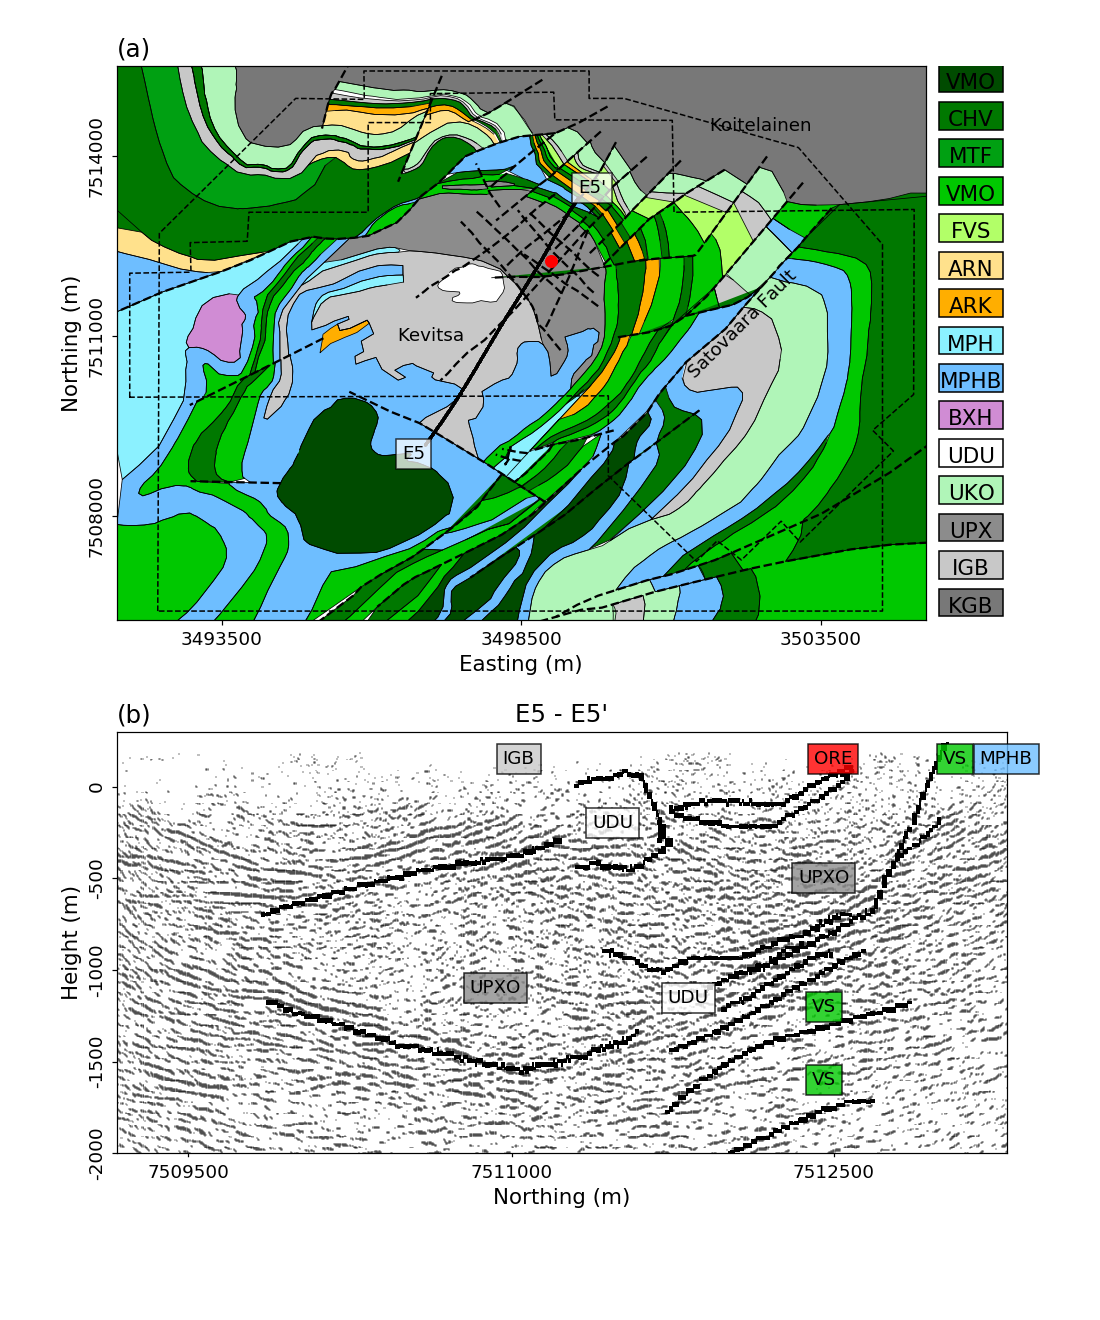

In [40]:
fig=plt.figure(figsize=(10,12))

yy = [7508000, 7511000, 7514000]
xx = [3493500, 3498500, 3503500]
xlim = [3491750, 3505250]
ylim = [7506250, 7515500]
zlim = [-2000,300]
zticks = np.arange(-2000,500,500)
zInd = 249

vmin, vmax = -.2, 0.2

# axs = plt.subplot()
# axs.axis('off')
# pos = axs.get_position()

# axs = plt.axes([pos.x0, pos.y0, pos.width*1, pos.height*1])
axs = plt.subplot(2,1,1)
plotGeology(VRTX,[], ax=axs, fill=True, linewidth=0.5, zorder=2)
im = plotGeology(VRTX,faults, faultsOnly=True, ax=axs, linewidth=1.5, zorder=2)

# axs, im2, cbar = plotModelSections(
#     meshXY, mSliceLpXY, axs=axs, cmap="pink_r", vmin=vmin, vmax=vmax, 
#     alpha=1., colorbar=False, contourf=False)


# if mLP is not None:
#     plotModelSections(
#         meshXY, xySliceLpXY, axs=axs, fill=False,
#         subFact=int(subFact/8), scale=scale*2., vec='w')

plt.plot(hullMAG[:, 0], hullMAG[:, 1], 'k--', linewidth=1.)
plt.plot(hullGRAV[:, 0], hullGRAV[:, 1], 'k--', linewidth=1.)


axs.plot(3499000, 7512250,'r.',markersize=15)
# axs.text(3499200, 7512250,'Ni-Cu',bbox={'facecolor':'white', 'alpha':0.75},ha='left', va='center', size=10)
axs.text(3497000, 7511000,'Kevitsa',ha='center', va='center', size=12)
axs.text(3502200, 7511200,'Satovaara Fault',ha='center', va='center', size=12, rotation=45)
axs.text(3502500, 7514500,'Koitelainen',ha='center', va='center', size=12)

plt.scatter(xxE5,yyE5,1,c='k')
axs.text(xxE5[0], yyE5[0], 'E5', ha="right", va="top", size=12, bbox={'facecolor':'white', 'alpha':0.75})
axs.text(xxE5[-1], yyE5[-1], "E5'", ha="left", va="bottom", size=12, bbox={'facecolor':'white', 'alpha':0.75})
# plt.scatter(xxE2,yyE2,1,c='k')
# axs.text(xxE2[0], yyE2[0], 'E2', ha="right", va="center", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# axs.text(xxE2[-1], yyE2[-1], "E2'", ha="left", va="center", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# plt.scatter(xxE2,yyE2,1,c='k')
# axs.text(xxE2[0], yyE2[0], 'E2', ha="right", va="center", size=14, bbox={'facecolor':'white', 'alpha':0.75})
# axs.text(xxE2[-1], yyE2[-1], "E2'", ha="left", va="center", size=14, bbox={'facecolor':'white', 'alpha':0.75})

axs.set_xlim(xlim)
axs.set_ylim(ylim)

axs.set_xticks(list(map(int, xx)))
axs.set_xticklabels(map(str, map(int, xx)),size=12)
axs.set_ylabel('Northing (m)', size=14)
axs.set_xlabel('Easting (m)', size=14)

axs.set_yticks(list(map(int, yy)))
axs.set_yticklabels(map(str, map(int, yy)),size=12, rotation=90, va='center')
axs.grid(True, 'k')
axs.set_aspect('equal')

axs.set_title("(a)", loc="left", size=16)
pos = axs.get_position()
axs.set_position([pos.x0-.1, pos.y0, pos.width*1.2, pos.height*1.2])

pos = axs.get_position()
ax2 = plt.axes([pos.x0+0.74, pos.y0, pos.width*0.1, pos.height])
ii = .1
jj=-0.06
for label in units:   
    jj +=0.0675
#     if jj > 0.9:
#         ii += 0.2
#         jj=0.05
    pp = ax2.add_patch(
        patches.Rectangle([ii,0+jj], 0.8, 0.05, facecolor=cpool[label], edgecolor='k'))
#     ax.text(26,62, 'Title',fontsize = 14,zorder = 6, color = 'k',
#                 bbox={'facecolor':'silver', 'alpha':0.5, 'pad':4})
    ax2.text(ii+0.4,0+jj+0.0175,lithoLabel[label], va='center', ha='center', size=14 )
    
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off')


# Add E5 section
ax2=plt.subplot(2,1,2)
ax2.set_position([pos.x0, pos.y0-.475, pos.width*1.1, pos.height*1.1])

# ax2=plt.axes([pos.x0+0.5, pos.y0, pos.width*.75, pos.height*.75]) #plt.subplot(3,1,1)
temp = mkvc(np.fliplr(DataE5.T))
temp[temp<np.percentile(temp,85)] = np.nan

# plotModelSections(
#     meshE5, mSliceLpE5, axs=ax2, cmap="RdYlBu_r", vmin=vmin, vmax=vmax, 
#     alpha=.5, colorbar=False, contourf=True, vec='w')
plotModelSections(meshE5,geoSliceE5, axs=ax2, cmap="gray_r", vmin=0, vmax=2, alpha=1, colorbar=False)
im2 = meshE5.plotImage(temp, clim=[-1,1], ax=ax2, pcolorOpts={"cmap":"gray_r","alpha":0.25})

# if mLP is not None:
#     plotModelSections(
#         meshE5, xySliceLpE5, axs=ax2, fill=False,
#         subFact=subFact, scale=scale, vec='w')

E2x = llE5[np.argmin(np.abs(xxE5-xx[1]))]
# plt.plot(np.r_[E2x, E2x], zlim, "k--", linewidth=4)
# plt.plot(np.r_[llE5.min(), llE5.max()], [mesh.vectorCCz[zInd]]*2, "k--", linewidth=4)
# ax2.text(E2x, zlim[0], "E2", ha="center", va="bottom", size=14, color='w', bbox={'facecolor':'black'})
ax2.text(E2x-800, -1100, "UPXO", ha="right", va="center", size=12, bbox={'facecolor':cpool['Opx'], 'alpha':0.8})
ax2.text(E2x, -1200, "UDU", ha="left", va="bottom", size=12, bbox={'facecolor':cpool['Dunite'], 'alpha':0.8})
ax2.text(E2x - 300, -200, "UDU", ha="center", va="center", size=12, bbox={'facecolor':cpool['Dunite'], 'alpha':0.8})
ax2.text(E2x + 850, -500, "UPXO", ha="center", va="center", size=12, bbox={'facecolor':cpool['Opx'], 'alpha':0.8})
ax2.text(E2x + 900, 100, "ORE", ha="center", va="bottom", size=12, bbox={'facecolor':'red', 'alpha':0.8})
ax2.text(E2x-900, 100, "IGB", ha="left", va="bottom", size=12, bbox={'facecolor':cpool['Gabbro'], 'alpha':0.8})
ax2.text(E2x+1700, 100, "MPHB", ha="left", va="bottom", size=12, bbox={'facecolor':cpool['CarbPhy'], 'alpha':0.8})
ax2.text(E2x+ 850, -1200, "VS", ha="center", va="center", size=12, bbox={'facecolor':cpool['MaficVol'], 'alpha':0.8})
ax2.text(E2x+1500, 100, "VS", ha="left", va="bottom", size=12, bbox={'facecolor':cpool['MaficVol'], 'alpha':0.8})
ax2.text(E2x+ 850, -1600, "VS", ha="center", va="center", size=12, bbox={'facecolor':cpool['MaficVol'], 'alpha':0.8})

# x = np.arange(3497150, 3499500, 1000)
x = np.arange(7509500, 7514000, 1500)
ax2.set_xticks([llE5[np.argmin(np.abs(yyE5-a))] for a in x])
ax2.set_xticklabels(map(str, map(int,[np.round(yyE5[np.argmin(np.abs(yyE5-a))]/10)*10 for a in x])),size=12, backgroundcolor='w')
ax2.xaxis.get_label().set_backgroundcolor('w')
ax2.set_ylim(zlim)
ax2.set_xlim([0,llE5[-1]])
ax2.set_xlabel("Northing (m)", size=14)
ax2.set_yticks(zticks)
ax2.set_yticklabels(map(str, map(int, zticks)),size=12, rotation=90, va='center')
# ax2.yaxis.set_label_position("right")
# ax2.yaxis.tick_right()


ax2.set_ylabel("Height (m)", size=14)
ax2.set_title("(b)", loc="left", size=16)
ax2.set_title("E5 - E5'", loc='center', size=16)
# ax2.set_title("E5'", loc='right', size=16)
ax2.set_aspect('equal')

fig.savefig("Kevitsa_Geol_SeisSections.png", bbox_inches='tight', dpi=300)

# Only Grav Mag maps

<IPython.core.display.Javascript object>


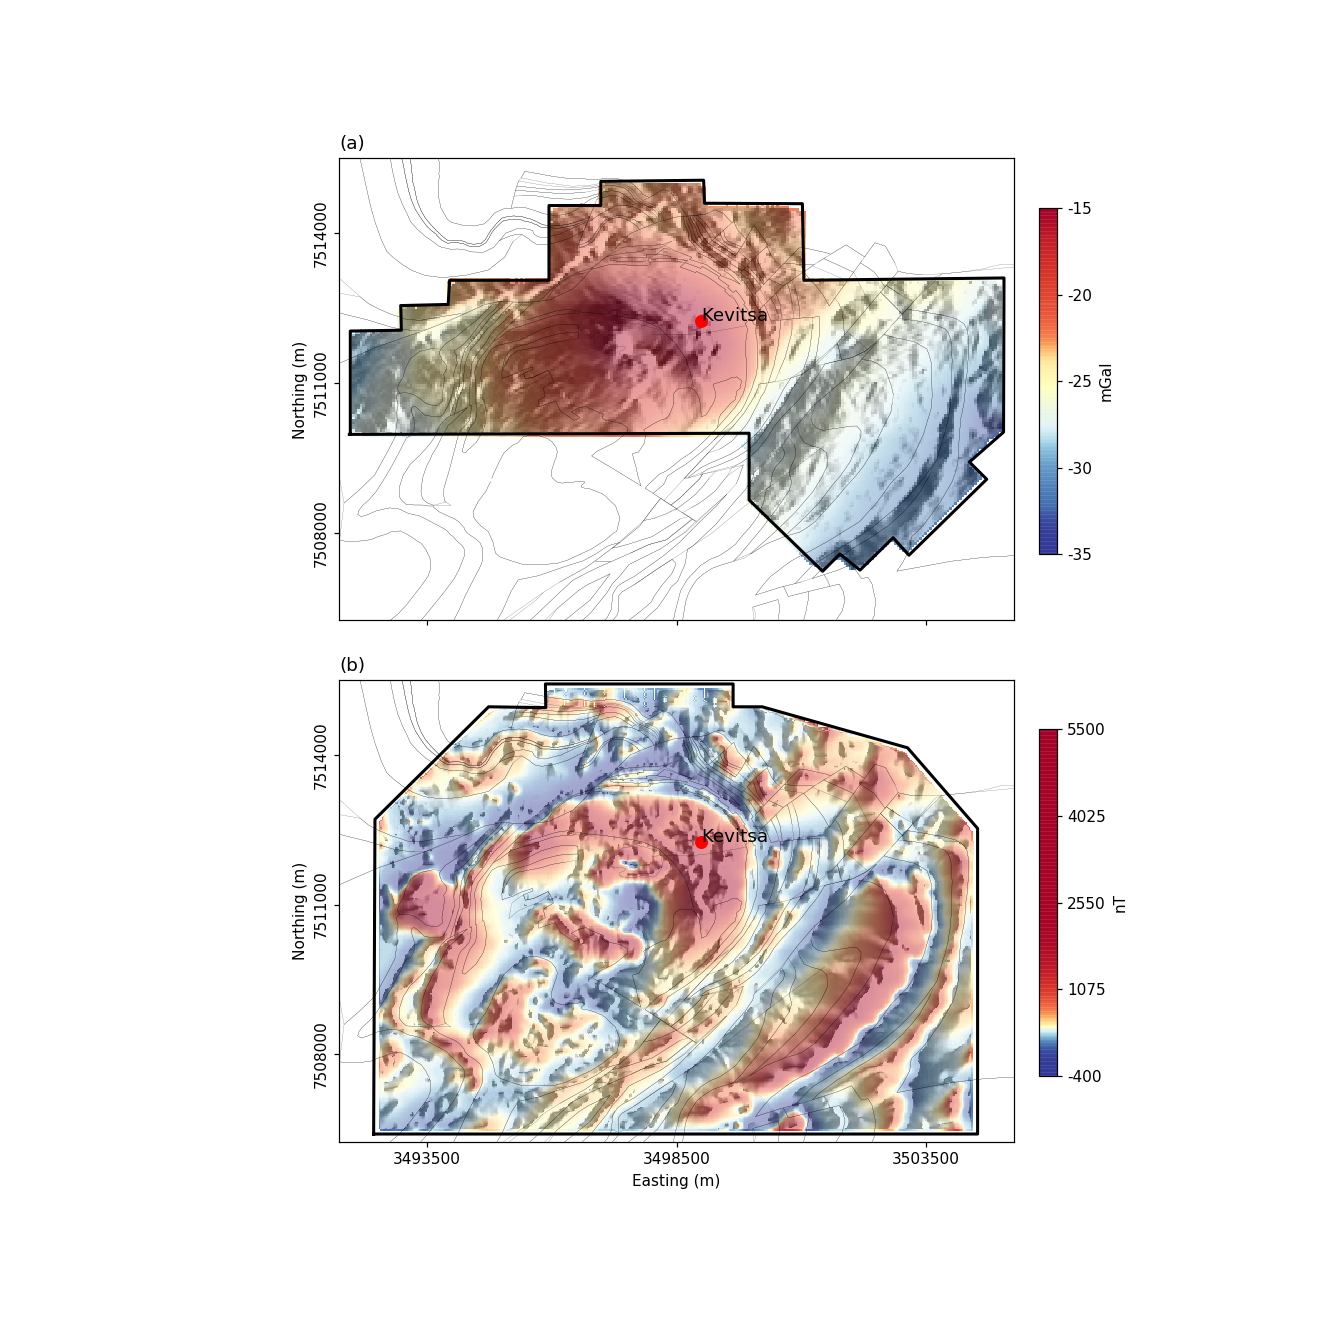

In [38]:


fig=plt.figure(figsize=(12,12))


y = [7508000, 7511000, 7514000]
x = [3493500, 3498500, 3503500]
xlim = [3491750, 3505250]
ylim = [7506250, 7515500]


axs=plt.subplot(2,1,1)
vmin = -35
vmax = -15

plotGeology(VRTX,[], ax=axs, faultsOnly=False, fill=False, linewidth=0.1, zorder=4)
# plotGeology(VRTX,faults, ax=axs, faultsOnly=True, fill=False, linewidth=2.)
X, Y, d_grid, im, CS = GeoToolkit.Mag.Simulator.plotDataHillside(
    GRAVsurvey.srcField.rxList[0].locs[:,0], 
    GRAVsurvey.srcField.rxList[0].locs[:,1], 
    GRAVsurvey.dobs, axs=axs, fill=True, contours=None, minCurvature=False,
                     vmin=vmin, vmax=vmax, resolution=50,
                     clabel=True, cmap='RdYlBu_r', ve=500., alpha=.9, alphaHS=0.5,
                     distMax=100, azdeg=270, altdeg=45,
                     equalizeHist='HistEqualized')

# plt.scatter(GRAVsurvey.rxLoc[:,0], GRAVsurvey.rxLoc[:,1], 0.1, c='k')

axs.plot(3499000, 7512250,'r.',markersize=15)
axs.text(3499000, 7512250,'Kevitsa', size=12)
plt.plot(hullGRAV[:, 0], hullGRAV[:, 1], 'k', linewidth=2.)

axs.set_axisbelow(False)
axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.set_xticks(list(map(int, x)))
axs.set_xticklabels([])
axs.set_xlabel("")
axs.set_title("(a)", loc='left')
axs.set_yticks(list(map(int, y)))
axs.set_yticklabels(map(str, map(int, y)),size=10, rotation=90, va='center')
axs.set_ylabel('Northing (m)', size=10)
axs.grid(False)
axs.set_aspect('equal')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0, pos.width*1.0, pos.height*1.0])

pos = axs.get_position()
axbar = plt.axes([pos.x0+0.4, pos.y0+0.05,  pos.width*.3, pos.height*.75])
cbar = plt.colorbar(im, orientation='vertical',format='%.0f')
cbar.set_ticks(np.linspace(vmin,vmax,5))
cbar.set_label("mGal", size=10)
# axbar.text(pos.x0, pos.y0-.5,'mGal', size=10)
axbar.axis('off')

            



# Plot gravity
axs = plt.subplot(2,1,2)



vmin, vmax = [-400, 5500]


X, Y, d_grid, im, CS = GeoToolkit.Mag.Simulator.plotDataHillside(
                        MAGsurvey.srcField.rxList[0].locs[:,0],
                        MAGsurvey.srcField.rxList[0].locs[:,1], 
                        MAGsurvey.dobs , minCurvature=False,
                          axs=axs, vmin=vmin, vmax=vmax, 
                          resolution=25,
                         clabel=True, cmap='RdYlBu_r', ve=500., alpha=.9, alphaHS=0.5,
                         distMax=100, azdeg=270, altdeg=45,
                         equalizeHist='HistEqualized')

# plt.scatter(MAGsurvey.rxLoc[:,0], MAGsurvey.rxLoc[:,1], 0.1, c='k')
plotGeology(VRTX,[], ax=axs, faultsOnly=False, fill=False, linewidth=0.1, zorder=4)
plt.plot(hullMAG[:, 0], hullMAG[:, 1], 'k', linewidth=2.)
axs.plot(3499000, 7512250,'r.',markersize=15)
axs.text(3499000, 7512250,'Kevitsa', size=12)

axs.set_axisbelow(False)
axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.set_xticks(list(map(int, x)))
axs.set_xticklabels(map(str, map(int, x)),size=10, ha='center')
axs.set_xlabel('Easting (m)', size=10)
axs.set_title("(b)", loc='left')
axs.set_yticks(list(map(int, y)))
axs.set_yticklabels(map(str, map(int, y)),size=10, rotation=90, va='center')
axs.set_ylabel('Northing (m)', size=10)
axs.grid(False)
axs.set_aspect('equal')
pos = axs.get_position()
axs.set_position([pos.x0, pos.y0+0.025, pos.width*1.0, pos.height*1.0])

pos = axs.get_position()
axbar = plt.axes([pos.x0+0.4, pos.y0+0.05,  pos.width*.3, pos.height*.75])
cbar = plt.colorbar(im, orientation='vertical',format='%.0f')
cbar.set_ticks(np.linspace(vmin,vmax,5))
cbar.set_label("nT", size=10)
# axbar.text(pos.x0, pos.y0-.5,'mGal', size=10)
axbar.axis('off')

fig.savefig("Kevitsa_PF_Data.png", bbox_inches='tight', dpi=300)